In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [19]:
train_df = pd.read_csv('/kaggle/input/something/train_data.txt', 
                       sep=':::', 
                       names=['ID', 'TITLE', 'GENRE', 'DESCRIPTION'], 
                       engine='python')
test_df = pd.read_csv('/kaggle/input/something/test_data.txt', 
                      sep=':::', 
                      names=['ID', 'TITLE', 'DESCRIPTION'], 
                      engine='python')
train_df.head()

,ID,TITLE,GENRE,DESCRIPTION
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [20]:
print(f"Train Data Shape: {train_df.shape}")
train_df.isnull().sum()
train_df['GENRE'].head(10)

Train Data Shape: (54214, 4)


0           drama 
1        thriller 
2           adult 
3           drama 
4           drama 
5     documentary 
6          comedy 
7           crime 
8      reality-tv 
9          horror 
Name: GENRE, dtype: object

In [21]:
train_df['GENRE'] = train_df['GENRE'].apply(lambda x: x.split(','))
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(train_df['GENRE'])
print(f"Genres: {mlb.classes_}")

Genres: [' action ' ' adult ' ' adventure ' ' animation ' ' biography ' ' comedy '
 ' crime ' ' documentary ' ' drama ' ' family ' ' fantasy ' ' game-show '
 ' history ' ' horror ' ' music ' ' musical ' ' mystery ' ' news '
 ' reality-tv ' ' romance ' ' sci-fi ' ' short ' ' sport ' ' talk-show '
 ' thriller ' ' war ' ' western ']


In [22]:
#creating text cleaning funtion
def clean_text(text):
    #Lowercase
    text = text.lower()
    #Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    #Tokenize
    tokens = text.split()
    #Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    #Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)
    
#Apply cleaning to descriptions
train_df['clean_description'] = train_df['DESCRIPTION'].apply(clean_text)

#Preview cleaned text
train_df[['DESCRIPTION', 'clean_description']].head()

,DESCRIPTION,clean_description
0,Listening in to a conversation between his do...,listening conversation doctor parent yearold o...
1,A brother and sister with a past incestuous r...,brother sister past incestuous relationship cu...
2,As the bus empties the students for their fie...,bus empty student field trip museum natural hi...
3,To help their unemployed father make ends mee...,help unemployed father make end meet edith twi...
4,The film's title refers not only to the un-re...,film title refers unrecovered body ground zero...


In [23]:
#Splitting data into train and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(
    train_df['clean_description'], 
    y, 
    test_size=0.2, 
    random_state=42
)

In [24]:
#Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000)

#Fit and transform on training data
X_train_tfidf = tfidf.fit_transform(X_train)

#Transform validation data
X_val_tfidf = tfidf.transform(X_val)

#Check TF-IDF shape
print(f"TF-IDF Train shape: {X_train_tfidf.shape}")
print(f"TF-IDF Validation shape: {X_val_tfidf.shape}")

TF-IDF Train shape: (43371, 5000)
TF-IDF Validation shape: (10843, 5000)


In [25]:
#importing and training the model
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

#Initialize Logistic Regression
logreg = LogisticRegression(solver='liblinear', max_iter=1000)

#Wrap it in OneVsRestClassifier for multi-label classification
model = OneVsRestClassifier(logreg)

#Train the model
model.fit(X_train_tfidf, y_train)

OneVsRestClassifier(estimator=LogisticRegression(max_iter=1000,
                                                 solver='liblinear'))

In [26]:
#Predict on validation set
y_val_pred = model.predict(X_val_tfidf)

In [27]:
#Accuracy
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

#Classification report
print("Classification Report:")
print(classification_report(y_val, y_val_pred, target_names=mlb.classes_))

Validation Accuracy: 0.3492
Classification Report:
               precision    recall  f1-score   support

      action        0.80      0.06      0.11       263
       adult        0.90      0.08      0.15       112
   adventure        0.50      0.04      0.07       139
   animation        0.00      0.00      0.00       104
   biography        0.00      0.00      0.00        61
      comedy        0.75      0.29      0.42      1443
       crime        1.00      0.01      0.02       107
 documentary        0.80      0.67      0.73      2659
       drama        0.68      0.45      0.54      2697
      family        1.00      0.03      0.05       150
     fantasy        0.00      0.00      0.00        74
   game-show        1.00      0.25      0.40        40
     history        0.00      0.00      0.00        45
      horror        0.80      0.31      0.45       431
       music        0.65      0.22      0.33       144
     musical        0.00      0.00      0.00        50
     mystery 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
print(classification_report(y_val, y_val_pred, target_names=mlb.classes_, zero_division=0))

               precision    recall  f1-score   support

      action        0.80      0.06      0.11       263
       adult        0.90      0.08      0.15       112
   adventure        0.50      0.04      0.07       139
   animation        0.00      0.00      0.00       104
   biography        0.00      0.00      0.00        61
      comedy        0.75      0.29      0.42      1443
       crime        1.00      0.01      0.02       107
 documentary        0.80      0.67      0.73      2659
       drama        0.68      0.45      0.54      2697
      family        1.00      0.03      0.05       150
     fantasy        0.00      0.00      0.00        74
   game-show        1.00      0.25      0.40        40
     history        0.00      0.00      0.00        45
      horror        0.80      0.31      0.45       431
       music        0.65      0.22      0.33       144
     musical        0.00      0.00      0.00        50
     mystery        0.00      0.00      0.00        56
        n

In [29]:
print(mlb.classes_)

[' action ' ' adult ' ' adventure ' ' animation ' ' biography ' ' comedy '
 ' crime ' ' documentary ' ' drama ' ' family ' ' fantasy ' ' game-show '
 ' history ' ' horror ' ' music ' ' musical ' ' mystery ' ' news '
 ' reality-tv ' ' romance ' ' sci-fi ' ' short ' ' sport ' ' talk-show '
 ' thriller ' ' war ' ' western ']


In [30]:
#Strip whitespace from genre labels
cleaned_classes = [genre.strip() for genre in mlb.classes_]

In [31]:
from sklearn.metrics import confusion_matrix

#Flatten the multi-label arrays into 1D vectors
y_val_flat = y_val.ravel()
y_val_pred_flat = y_val_pred.ravel()

#Compute confusion matrix
global_cm = confusion_matrix(y_val_flat, y_val_pred_flat)

#Show the matrix
print(global_cm)

[[280638   1280]
 [  6970   3873]]


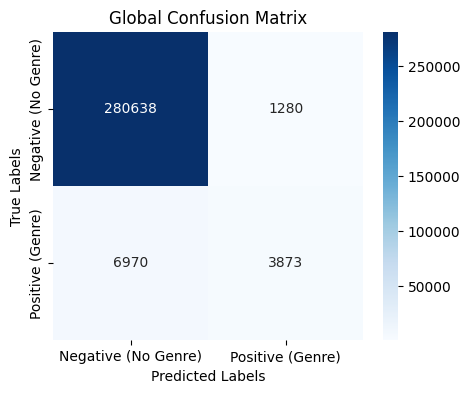

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

#Define labels for the confusion matrix
labels = ['Negative (No Genre)', 'Positive (Genre)']

#Plot the heatmap
plt.figure(figsize=(5,4))
sns.heatmap(global_cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Global Confusion Matrix')
plt.show()

In [34]:
import joblib

#Save Logistic Regression model
joblib.dump(model, 'logistic_regression_model.pkl')

#Save TF-IDF Vectorizer (needed for inference)
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

In [36]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=50,        
    max_depth=10,           
    max_features='sqrt',    
    n_jobs=-1,              
    random_state=42
)

rf_model = OneVsRestClassifier(rf)

rf_model.fit(X_train_tfidf, y_train)

OneVsRestClassifier(estimator=RandomForestClassifier(max_depth=10,
                                                     n_estimators=50, n_jobs=-1,
                                                     random_state=42))

In [37]:
#Predict on validation set
y_val_pred_rf = rf_model.predict(X_val_tfidf)

#Evaluate
rf_accuracy = accuracy_score(y_val, y_val_pred_rf)
print(f"Random Forest Validation Accuracy: {rf_accuracy:.4f}")
print("Random Forest Classification Report:")
print(classification_report(y_val, y_val_pred_rf, target_names=cleaned_classes, zero_division=0))

Random Forest Validation Accuracy: 0.0103
Random Forest Classification Report:
              precision    recall  f1-score   support

      action       0.00      0.00      0.00       263
       adult       0.00      0.00      0.00       112
   adventure       0.00      0.00      0.00       139
   animation       0.00      0.00      0.00       104
   biography       0.00      0.00      0.00        61
      comedy       0.00      0.00      0.00      1443
       crime       0.00      0.00      0.00       107
 documentary       0.92      0.04      0.07      2659
       drama       1.00      0.00      0.01      2697
      family       0.00      0.00      0.00       150
     fantasy       0.00      0.00      0.00        74
   game-show       0.00      0.00      0.00        40
     history       0.00      0.00      0.00        45
      horror       0.00      0.00      0.00       431
       music       1.00      0.01      0.03       144
     musical       0.00      0.00      0.00        50
  

In [38]:
#using SVM
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier

#Initialize SVM (Linear kernel, works best with sparse data)
svm = LinearSVC(max_iter=1000)

#Wrap in OneVsRestClassifier for multi-label classification
svm_model = OneVsRestClassifier(svm)

#Train SVM
svm_model.fit(X_train_tfidf, y_train)

OneVsRestClassifier(estimator=LinearSVC())

In [39]:
#Predict on validation set
y_val_pred_svm = svm_model.predict(X_val_tfidf)

#Evaluate
svm_accuracy = accuracy_score(y_val, y_val_pred_svm)
print(f"SVM Validation Accuracy: {svm_accuracy:.4f}")
print("SVM Classification Report:")
print(classification_report(y_val, y_val_pred_svm, target_names=cleaned_classes, zero_division=0))

SVM Validation Accuracy: 0.4003
SVM Classification Report:
              precision    recall  f1-score   support

      action       0.54      0.16      0.24       263
       adult       0.71      0.26      0.38       112
   adventure       0.44      0.12      0.18       139
   animation       0.40      0.06      0.10       104
   biography       0.00      0.00      0.00        61
      comedy       0.64      0.42      0.50      1443
       crime       0.40      0.02      0.04       107
 documentary       0.76      0.69      0.72      2659
       drama       0.62      0.51      0.56      2697
      family       0.35      0.07      0.12       150
     fantasy       0.50      0.01      0.03        74
   game-show       0.95      0.47      0.63        40
     history       0.00      0.00      0.00        45
      horror       0.71      0.50      0.59       431
       music       0.61      0.39      0.47       144
     musical       0.50      0.02      0.04        50
     mystery       0.5

In [40]:
import joblib

# Save SVM model
joblib.dump(svm_model, 'svm_model.pkl')

['svm_model.pkl']

In [41]:
#Logistic Regression Accuracy (from previous step)
logreg_accuracy = accuracy  # Already computed earlier

#Random Forest Accuracy (from previous step)
rf_accuracy = rf_accuracy   # Already computed earlier

#SVM Accuracy (just computed)
svm_accuracy = svm_accuracy

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


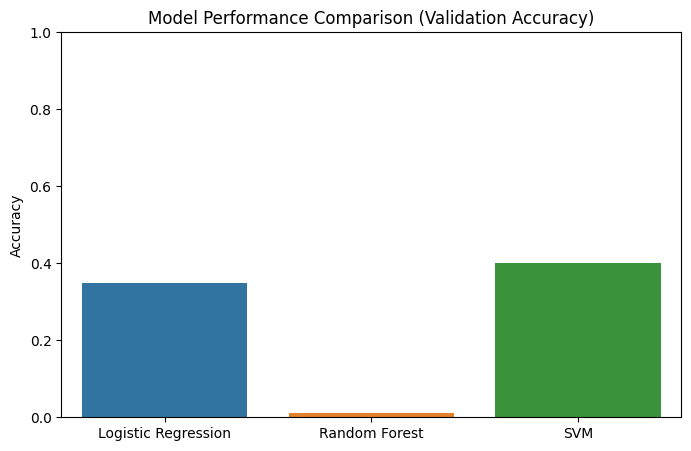

In [42]:
#plot accuracy comparison
import matplotlib.pyplot as plt
import seaborn as sns

#Create accuracy list
model_names = ['Logistic Regression', 'Random Forest', 'SVM']
accuracies = [logreg_accuracy, rf_accuracy, svm_accuracy]

#Plot bar chart
plt.figure(figsize=(8,5))
sns.barplot(x=model_names, y=accuracies)
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Model Performance Comparison (Validation Accuracy)')
plt.show()

In [43]:
#Tabular display
comparison_df = pd.DataFrame({
    'Model': model_names,
    'Validation Accuracy': accuracies
})

comparison_df

,Model,Validation Accuracy
0,Logistic Regression,0.349165
1,Random Forest,0.010329
2,SVM,0.400258


In [44]:
!pip install transformers
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 7.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.8.4.1 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cufft-cu12==11.2.1.3; platform_system == "Linux" and platform_machine == "x86_64", but you 

In [45]:
#BERT
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MultiLabelBinarizer

2025-04-28 20:06:16.984812: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745870777.166551      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745870777.217653      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [46]:
class MovieDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        labels = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.FloatTensor(labels)
        }

In [47]:
from transformers import BertTokenizer

#Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

#Max token length
MAX_LEN = 256

#Create datasets
train_dataset = MovieDataset(X_train.tolist(), y_train, tokenizer, MAX_LEN)
val_dataset = MovieDataset(X_val.tolist(), y_val, tokenizer, MAX_LEN)

#Create DataLoaders
BATCH_SIZE = 8

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [48]:
from transformers import BertForSequenceClassification

#Number of genres (labels)
num_labels = y.shape[1]

#Load pre-trained BERT with multi-label classification head
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels, problem_type="multi_label_classification")

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [49]:
from transformers import get_scheduler
from torch.optim import AdamW

#Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

#Learning rate scheduler
epochs = 3  # Start with 3 epochs (can increase)
total_steps = len(train_loader) * epochs

scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

#Loss function: Multi-label -> BCEWithLogitsLoss
loss_fn = torch.nn.BCEWithLogitsLoss()

In [50]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [51]:
from tqdm import tqdm

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler):
    model.train()
    total_loss = 0

    for batch in tqdm(data_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        loss = loss_fn(logits, labels)

        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return total_loss / len(data_loader)

def eval_epoch(model, data_loader, loss_fn, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch in tqdm(data_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            loss = loss_fn(logits, labels)
            total_loss += loss.item()

    return total_loss / len(data_loader)

In [52]:
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    
    train_loss = train_epoch(model, train_loader, loss_fn, optimizer, device, scheduler)
    print(f"Train Loss: {train_loss:.4f}")

    val_loss = eval_epoch(model, val_loader, loss_fn, device)
    print(f"Validation Loss: {val_loss:.4f}")

Epoch 1/3


100%|██████████| 5422/5422 [21:33<00:00,  4.19it/s]


Train Loss: 0.0950


100%|██████████| 1356/1356 [01:29<00:00, 15.09it/s]


Validation Loss: 0.0738
Epoch 2/3


100%|██████████| 5422/5422 [21:33<00:00,  4.19it/s]


Train Loss: 0.0631


100%|██████████| 1356/1356 [01:29<00:00, 15.11it/s]


Validation Loss: 0.0683
Epoch 3/3


100%|██████████| 5422/5422 [21:33<00:00,  4.19it/s]


Train Loss: 0.0491


100%|██████████| 1356/1356 [01:29<00:00, 15.11it/s]

Validation Loss: 0.0691


In [53]:
def get_predictions(model, data_loader):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in tqdm(data_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels']

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            probs = torch.sigmoid(logits).cpu().numpy()

            predictions.extend(probs)
            true_labels.extend(labels.numpy())

    return np.array(predictions), np.array(true_labels)

y_pred_probs, y_true = get_predictions(model, val_loader)

100%|██████████| 1356/1356 [01:29<00:00, 15.13it/s]


In [54]:
#Binarizing the bert predictions
y_pred = (y_pred_probs >= 0.5).astype(int)

In [55]:
#evaluate BERT
from sklearn.metrics import accuracy_score, classification_report

bert_accuracy = accuracy_score(y_true, y_pred)
print(f"BERT Validation Accuracy: {bert_accuracy:.4f}")

# Classification report
print("BERT Classification Report:")
print(classification_report(y_true, y_pred, target_names=cleaned_classes, zero_division=0))

BERT Validation Accuracy: 0.5846
BERT Classification Report:
              precision    recall  f1-score   support

      action       0.68      0.35      0.46       263
       adult       0.72      0.49      0.59       112
   adventure       0.60      0.18      0.28       139
   animation       0.00      0.00      0.00       104
   biography       0.00      0.00      0.00        61
      comedy       0.68      0.58      0.63      1443
       crime       0.00      0.00      0.00       107
 documentary       0.81      0.81      0.81      2659
       drama       0.69      0.68      0.69      2697
      family       0.71      0.10      0.18       150
     fantasy       0.00      0.00      0.00        74
   game-show       0.97      0.70      0.81        40
     history       0.00      0.00      0.00        45
      horror       0.68      0.75      0.71       431
       music       0.68      0.69      0.68       144
     musical       0.00      0.00      0.00        50
     mystery       0

In [ ]:
model.save_pretrained('bert_genre_classifier')
tokenizer.save_pretrained('bert_genre_classifier')

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


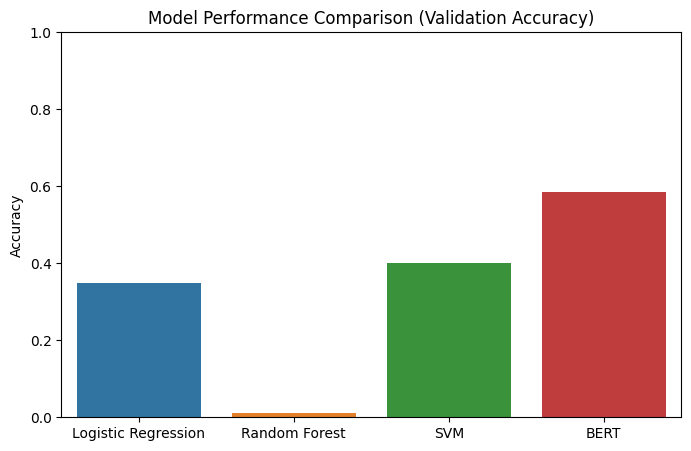

,Model,Validation Accuracy
0,Logistic Regression,0.349165
1,Random Forest,0.010329
2,SVM,0.400258
3,BERT,0.584617


In [58]:
# Comparison Table
model_names = ['Logistic Regression', 'Random Forest', 'SVM', 'BERT']
accuracies = [logreg_accuracy, rf_accuracy, svm_accuracy, bert_accuracy]

# Plot comparison
plt.figure(figsize=(8,5))
sns.barplot(x=model_names, y=accuracies)
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Model Performance Comparison (Validation Accuracy)')
plt.show()

# Tabular view
comparison_df = pd.DataFrame({
    'Model': model_names,
    'Validation Accuracy': accuracies
})

comparison_df